<a href="https://colab.research.google.com/github/potatosoupx/python/blob/main/ptb-colab/cardioid_EQ_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import scipy.signal as signal
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
result=pd.read_csv('/content/drive/MyDrive/result.csv')

In [3]:
p_vx=result['vx_sum'].iloc[280:440]
p_vy=result['vy_sum'].iloc[280:440]
p_vz=result['vz_sum'].iloc[280:440]

p_wave = pd.DataFrame({'vx': p_vx, 'vy': p_vy, 'vz': p_vz})

qrs_vx=result['vx_sum'].iloc[440:600]
qrs_vy=result['vy_sum'].iloc[440:600]
qrs_vz=result['vz_sum'].iloc[440:600]

qrs_wave = pd.DataFrame({'vx': qrs_vx, 'vy': qrs_vy, 'vz': qrs_vz})

t_vx=result['vx_sum'].iloc[600:940]
t_vy=result['vy_sum'].iloc[600:940]
t_vz=result['vz_sum'].iloc[600:940]

t_wave = pd.DataFrame({'vx': t_vx, 'vy': t_vy, 'vz': t_vz})

#fin

plane_x · plane_y: 0.0
plane_x · normal_vector: 1.6653345369377348e-16
plane_y · normal_vector: -2.220446049250313e-16


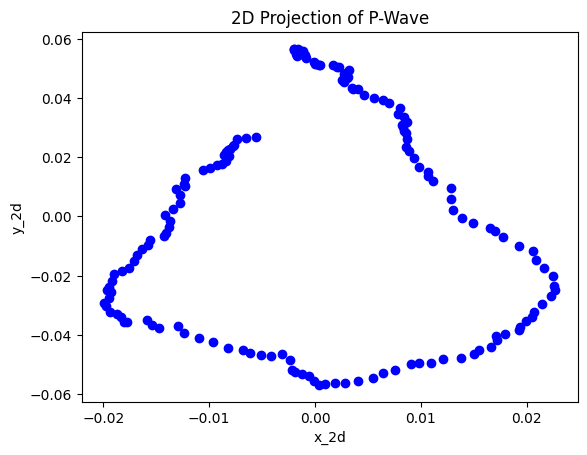

PCA 기반 평면 방정식: -0.6373x + 0.5526y + 0.5371z + 0.0015 = 0
x 방정식 추정: x = 0.0229 * cos(t) + 0.0007 * cos^2(t) + 0.0005
y 방정식 추정: y = 0.0412 * sin(t) + 0.0071 * sin(t) * cos(t) + -0.0016


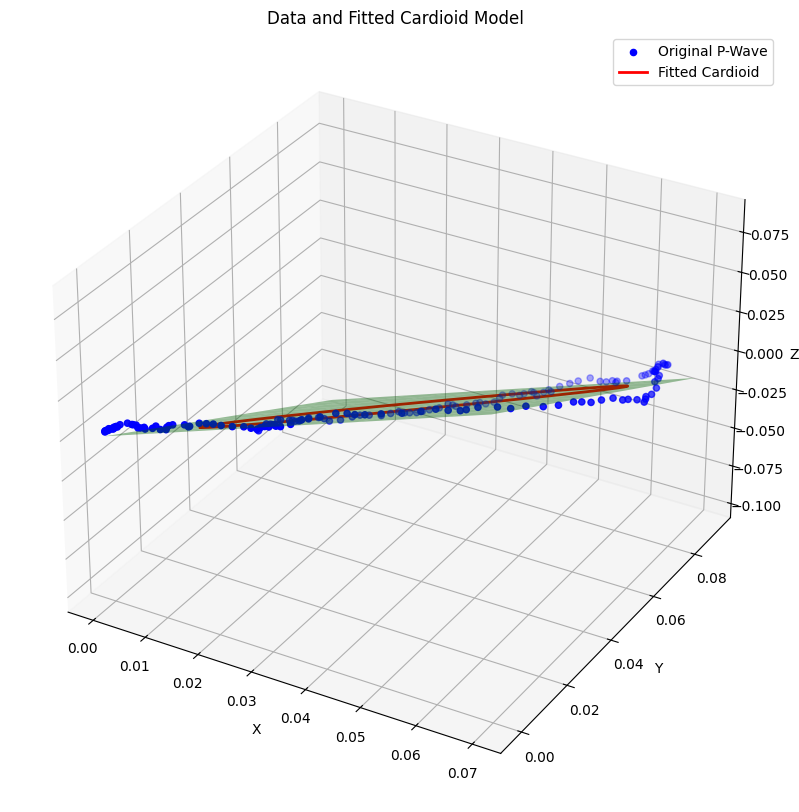

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

p_vx = p_wave['vx']
p_vy = p_wave['vy']
p_vz = p_wave['vz']

points = np.column_stack((p_vx, p_vy, p_vz)) #3D 배열

# PCA 평면 계산 (중심 이동 공분산 행렬, 고유벡터로 법선 벡터 생성)
centroid = np.mean(points, axis=0)
centered = points - centroid
cov = np.cov(centered.T)
eigvals, eigvecs = np.linalg.eigh(cov)
normal_vector = eigvecs[:, 0]  # 가장 작은 고유값에 대응되는 벡터
A_pca, B_pca, C_pca = normal_vector
D_pca = -np.dot(normal_vector, centroid)

# PCA 직교성 확인
plane_x = eigvecs[:, 1]
plane_y = eigvecs[:, 2]

print("plane_x · plane_y:", np.dot(plane_x, plane_y))
print("plane_x · normal_vector:", np.dot(plane_x, normal_vector))
print("plane_y · normal_vector:", np.dot(plane_y, normal_vector))

# 2D array
p_proj_2d = np.dot(centered, np.vstack([plane_x, plane_y]).T)
x_2d, y_2d = p_proj_2d[:, 0], p_proj_2d[:, 1]

plt.scatter(x_2d, y_2d, color='blue')
plt.title("2D Projection of P-Wave")
plt.xlabel("x_2d")
plt.ylabel("y_2d")
plt.show()

t = np.arctan2(y_2d, x_2d)  # 각도를 기반으로 t 계산

# 선형 회귀 행렬
cos_t = np.cos(t)
cos2_t = cos_t**2
sin_t = np.sin(t)
sin_cos_t = sin_t * cos_t
ones = np.ones_like(t)

A_x = np.vstack([cos_t, cos2_t, ones]).T
A_y = np.vstack([sin_t, sin_cos_t, ones]).T

coeffs_x, *_ = np.linalg.lstsq(A_x, x_2d, rcond=None)
coeffs_y, *_ = np.linalg.lstsq(A_y, y_2d, rcond=None)

# 모델 2D 곡선 생성
x_fit = A_x @ coeffs_x
y_fit = A_y @ coeffs_y

# 3D 변환
cardioid_3d = np.outer(x_fit, plane_x) + np.outer(y_fit, plane_y) + centroid

print(f"PCA 기반 평면 방정식: {A_pca:.4f}x + {B_pca:.4f}y + {C_pca:.4f}z + {D_pca:.4f} = 0")
print(f"x 방정식 추정: x = {coeffs_x[0]:.4f} * cos(t) + {coeffs_x[1]:.4f} * cos^2(t) + {coeffs_x[2]:.4f}")
print(f"y 방정식 추정: y = {coeffs_y[0]:.4f} * sin(t) + {coeffs_y[1]:.4f} * sin(t) * cos(t) + {coeffs_y[2]:.4f}")

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(p_vx, p_vy, p_vz, color='blue', label='Original P-Wave')
ax.plot(cardioid_3d[:, 0], cardioid_3d[:, 1], cardioid_3d[:, 2], color='red', linewidth=2, label='Fitted Cardioid')

xx, yy = np.meshgrid(
    np.linspace(np.min(p_vx), np.max(p_vx), 10),
    np.linspace(np.min(p_vy), np.max(p_vy), 10)
)
zz = (-A_pca * xx - B_pca * yy - D_pca) / C_pca
ax.plot_surface(xx, yy, zz, alpha=0.4, color='green')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Data and Fitted Cardioid Model')
ax.legend()
plt.show()

In [18]:
import numpy as np
import plotly.graph_objects as go

# 1. 데이터 로드
p_vx = p_wave['vx']
p_vy = p_wave['vy']
p_vz = p_wave['vz']

points = np.column_stack((p_vx, p_vy, p_vz))

# 2. PCA 기반 평면 계산
centroid = np.mean(points, axis=0)
centered = points - centroid
cov = np.cov(centered.T)
eigvals, eigvecs = np.linalg.eigh(cov)
normal_vector = eigvecs[:, 0]  # 가장 작은 고유값에 대응되는 벡터
A_pca, B_pca, C_pca = normal_vector
D_pca = -np.dot(normal_vector, centroid)

# PCA 평면의 직교성 확인
plane_x = eigvecs[:, 1]
plane_y = eigvecs[:, 2]

# 3. 평면 기준 좌표계로 투영된 데이터 (2D)
p_proj_2d = np.dot(centered, np.vstack([plane_x, plane_y]).T)
x_2d, y_2d = p_proj_2d[:, 0], p_proj_2d[:, 1]

# 4. 2D 상에서 카디오이드 회귀
t = np.arctan2(y_2d, x_2d)  # 각도를 기반으로 t 계산

# 선형 회귀를 위한 설계 행렬
cos_t = np.cos(t)
cos2_t = cos_t**2
sin_t = np.sin(t)
sin_cos_t = sin_t * cos_t
ones = np.ones_like(t)

A_x = np.vstack([cos_t, cos2_t, ones]).T
A_y = np.vstack([sin_t, sin_cos_t, ones]).T

coeffs_x, *_ = np.linalg.lstsq(A_x, x_2d, rcond=None)
coeffs_y, *_ = np.linalg.lstsq(A_y, y_2d, rcond=None)

# 모델 2D 곡선 생성
x_fit = A_x @ coeffs_x
y_fit = A_y @ coeffs_y

# 다시 3D로 변환 (투영 좌표계를 원래 공간으로 복원)
cardioid_3d = np.outer(x_fit, plane_x) + np.outer(y_fit, plane_y) + centroid

# 5. PCA 평면 생성
xx, yy = np.meshgrid(
    np.linspace(np.min(p_vx), np.max(p_vx), 10),
    np.linspace(np.min(p_vy), np.max(p_vy), 10)
)
zz = (-A_pca * xx - B_pca * yy - D_pca) / C_pca

# 6. Plotly 시각화
fig = go.Figure()

# 원본 데이터
fig.add_trace(go.Scatter3d(
    x=p_vx, y=p_vy, z=p_vz,
    mode='markers',
    marker=dict(size=3, color='blue'),
    name='Original P-Wave'
))

# 회귀된 카디오이드
fig.add_trace(go.Scatter3d(
    x=cardioid_3d[:, 0], y=cardioid_3d[:, 1], z=cardioid_3d[:, 2],
    mode='lines',
    line=dict(color='red', width=4),
    name='Fitted Cardioid'
))

# PCA 평면
fig.add_trace(go.Surface(
    x=xx, y=yy, z=zz,
    opacity=0.5,
    colorscale='Greens',
    name='PCA Plane'
))

# 레이아웃 설정
fig.update_layout(
    title="Data and Fitted Cardioid Model",
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    ),
    legend=dict(
        x=0.8, y=0.9
    )
)

fig.show()


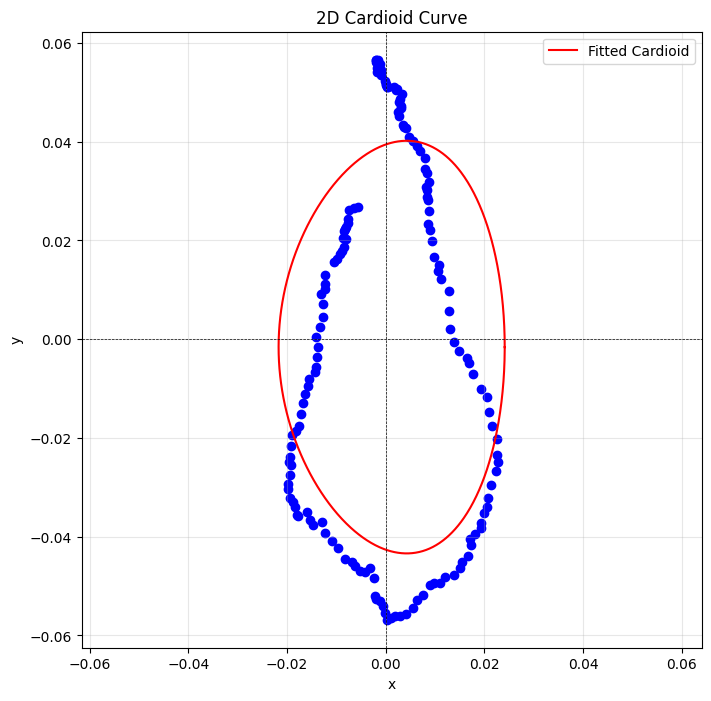

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# 1. t 값 범위 설정
t = np.linspace(0, 2 * np.pi, 1000)  # 0부터 2π까지 1000개의 점

# 2. x와 y 방정식 정의
x = 0.0229 * np.cos(t) +  0.0007 * (np.cos(t) ** 2) + 0.0005
y = 0.0412 * np.sin(t) + 0.0071 * np.sin(t) * np.cos(t) + -0.0016

# 3. 곡선 플롯
plt.figure(figsize=(8, 8))
plt.plot(x, y, color='red', label='Fitted Cardioid')
plt.scatter(x_2d, y_2d, color='blue')
plt.title("2D Cardioid Curve")
plt.xlabel("x")
plt.ylabel("y")
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.axvline(0, color='black', linewidth=0.5, linestyle='--')
plt.grid(alpha=0.3)
plt.legend()
plt.axis('equal')  # 축 비율을 동일하게 설정
plt.show()


plane_x · plane_y: 0.0
plane_x · normal_vector: 1.1102230246251565e-16
plane_y · normal_vector: -8.456776945386935e-17


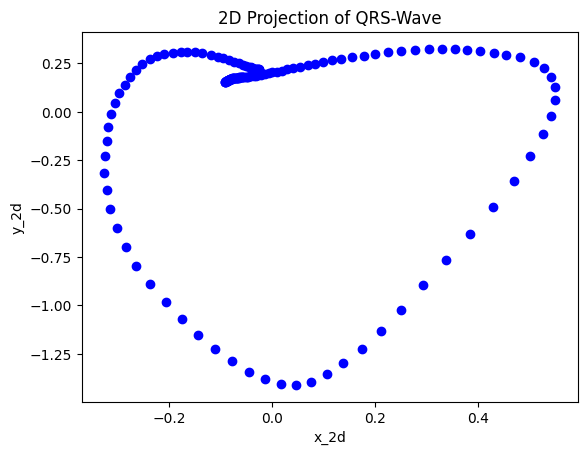

PCA 기반 평면 방정식: -0.3928x + 0.9098y + -0.1342z + -0.0225 = 0
x 방정식 추정: x = 0.4114 * cos(t) + 0.0926 * cos^2(t) + 0.0264
y 방정식 추정: y = 0.6313 * sin(t) + 0.2180 * sin(t) * cos(t) + -0.2986


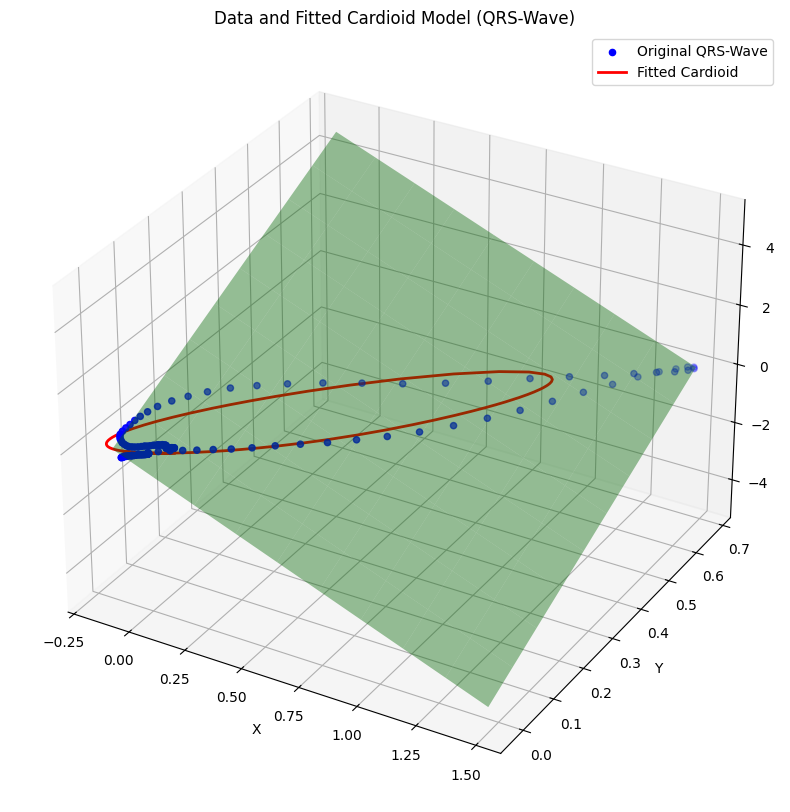

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 1. 데이터 로드
qrs_vx = qrs_wave['vx']
qrs_vy = qrs_wave['vy']
qrs_vz = qrs_wave['vz']

points = np.column_stack((qrs_vx, qrs_vy, qrs_vz))

# 2. PCA 기반 평면 계산
centroid = np.mean(points, axis=0)
centered = points - centroid
cov = np.cov(centered.T)
eigvals, eigvecs = np.linalg.eigh(cov)
normal_vector = eigvecs[:, 0]  # 가장 작은 고유값에 대응되는 벡터
A_pca, B_pca, C_pca = normal_vector
D_pca = -np.dot(normal_vector, centroid)

# PCA 평면의 직교성 확인
plane_x = eigvecs[:, 1]
plane_y = eigvecs[:, 2]

print("plane_x · plane_y:", np.dot(plane_x, plane_y))
print("plane_x · normal_vector:", np.dot(plane_x, normal_vector))
print("plane_y · normal_vector:", np.dot(plane_y, normal_vector))

# 3. 평면 기준 좌표계로 투영된 데이터 (2D)
qrs_proj_2d = np.dot(centered, np.vstack([plane_x, plane_y]).T)
x_2d, y_2d = qrs_proj_2d[:, 0], qrs_proj_2d[:, 1]

# 투영된 데이터 시각화
plt.scatter(x_2d, y_2d, color='blue')
plt.title("2D Projection of QRS-Wave")
plt.xlabel("x_2d")
plt.ylabel("y_2d")
plt.show()

# 4. 2D 상에서 카디오이드 회귀
t = np.arctan2(y_2d, x_2d)  # 각도를 기반으로 t 계산

# 선형 회귀를 위한 설계 행렬
cos_t = np.cos(t)
cos2_t = cos_t**2
sin_t = np.sin(t)
sin_cos_t = sin_t * cos_t
ones = np.ones_like(t)

A_x = np.vstack([cos_t, cos2_t, ones]).T
A_y = np.vstack([sin_t, sin_cos_t, ones]).T

coeffs_x, *_ = np.linalg.lstsq(A_x, x_2d, rcond=None)
coeffs_y, *_ = np.linalg.lstsq(A_y, y_2d, rcond=None)

# 모델 2D 곡선 생성
x_fit = A_x @ coeffs_x
y_fit = A_y @ coeffs_y

# 다시 3D로 변환 (투영 좌표계를 원래 공간으로 복원)
cardioid_3d = np.outer(x_fit, plane_x) + np.outer(y_fit, plane_y) + centroid

# 5. 결과 출력
print(f"PCA 기반 평면 방정식: {A_pca:.4f}x + {B_pca:.4f}y + {C_pca:.4f}z + {D_pca:.4f} = 0")
print(f"x 방정식 추정: x = {coeffs_x[0]:.4f} * cos(t) + {coeffs_x[1]:.4f} * cos^2(t) + {coeffs_x[2]:.4f}")
print(f"y 방정식 추정: y = {coeffs_y[0]:.4f} * sin(t) + {coeffs_y[1]:.4f} * sin(t) * cos(t) + {coeffs_y[2]:.4f}")

# 6. 시각화
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# 원본 데이터
ax.scatter(qrs_vx, qrs_vy, qrs_vz, color='blue', label='Original QRS-Wave')

# 회귀된 카디오이드
ax.plot(cardioid_3d[:, 0], cardioid_3d[:, 1], cardioid_3d[:, 2], color='red', linewidth=2, label='Fitted Cardioid')

# PCA 평면 시각화
xx, yy = np.meshgrid(
    np.linspace(np.min(qrs_vx), np.max(qrs_vx), 10),
    np.linspace(np.min(qrs_vy), np.max(qrs_vy), 10)
)
zz = (-A_pca * xx - B_pca * yy - D_pca) / C_pca
ax.plot_surface(xx, yy, zz, alpha=0.4, color='green')

# 라벨 및 범례
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Data and Fitted Cardioid Model (QRS-Wave)')
ax.legend()
plt.show()


In [21]:
import numpy as np
import plotly.graph_objects as go

# 1. 데이터 로드
qrs_vx = qrs_wave['vx']
qrs_vy = qrs_wave['vy']
qrs_vz = qrs_wave['vz']

points = np.column_stack((qrs_vx, qrs_vy, qrs_vz))

# 2. PCA 기반 평면 계산
centroid = np.mean(points, axis=0)
centered = points - centroid
cov = np.cov(centered.T)
eigvals, eigvecs = np.linalg.eigh(cov)
normal_vector = eigvecs[:, 0]  # 가장 작은 고유값에 대응되는 벡터
A_pca, B_pca, C_pca = normal_vector
D_pca = -np.dot(normal_vector, centroid)

# PCA 평면의 직교성 확인
plane_x = eigvecs[:, 1]
plane_y = eigvecs[:, 2]

# 3. 평면 기준 좌표계로 투영된 데이터 (2D)
qrs_proj_2d = np.dot(centered, np.vstack([plane_x, plane_y]).T)
x_2d, y_2d = qrs_proj_2d[:, 0], qrs_proj_2d[:, 1]

# 4. 2D 상에서 카디오이드 회귀
t = np.arctan2(y_2d, x_2d)  # 각도를 기반으로 t 계산

# 선형 회귀를 위한 설계 행렬
cos_t = np.cos(t)
cos2_t = cos_t**2
sin_t = np.sin(t)
sin_cos_t = sin_t * cos_t
ones = np.ones_like(t)

A_x = np.vstack([cos_t, cos2_t, ones]).T
A_y = np.vstack([sin_t, sin_cos_t, ones]).T

coeffs_x, *_ = np.linalg.lstsq(A_x, x_2d, rcond=None)
coeffs_y, *_ = np.linalg.lstsq(A_y, y_2d, rcond=None)

# 모델 2D 곡선 생성
x_fit = A_x @ coeffs_x
y_fit = A_y @ coeffs_y

# 다시 3D로 변환 (투영 좌표계를 원래 공간으로 복원)
cardioid_3d = np.outer(x_fit, plane_x) + np.outer(y_fit, plane_y) + centroid

# 5. PCA 평면 생성
xx, yy = np.meshgrid(
    np.linspace(np.min(qrs_vx), np.max(qrs_vx), 10),
    np.linspace(np.min(qrs_vy), np.max(qrs_vy), 10)
)
zz = (-A_pca * xx - B_pca * yy - D_pca) / C_pca

# 6. Plotly 시각화
fig = go.Figure()

# 원본 데이터
fig.add_trace(go.Scatter3d(
    x=qrs_vx, y=qrs_vy, z=qrs_vz,
    mode='markers',
    marker=dict(size=3, color='blue'),
    name='Original QRS-Wave'
))

# 회귀된 카디오이드
fig.add_trace(go.Scatter3d(
    x=cardioid_3d[:, 0], y=cardioid_3d[:, 1], z=cardioid_3d[:, 2],
    mode='lines',
    line=dict(color='red', width=4),
    name='Fitted Cardioid'
))

# PCA 평면
fig.add_trace(go.Surface(
    x=xx, y=yy, z=zz,
    opacity=0.5,
    colorscale='Greens',
    name='PCA Plane'
))

# 레이아웃 설정
fig.update_layout(
    title="Data and Fitted Cardioid Model (QRS-Wave)",
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    ),
    legend=dict(
        x=0.8, y=0.9
    )
)

fig.show()


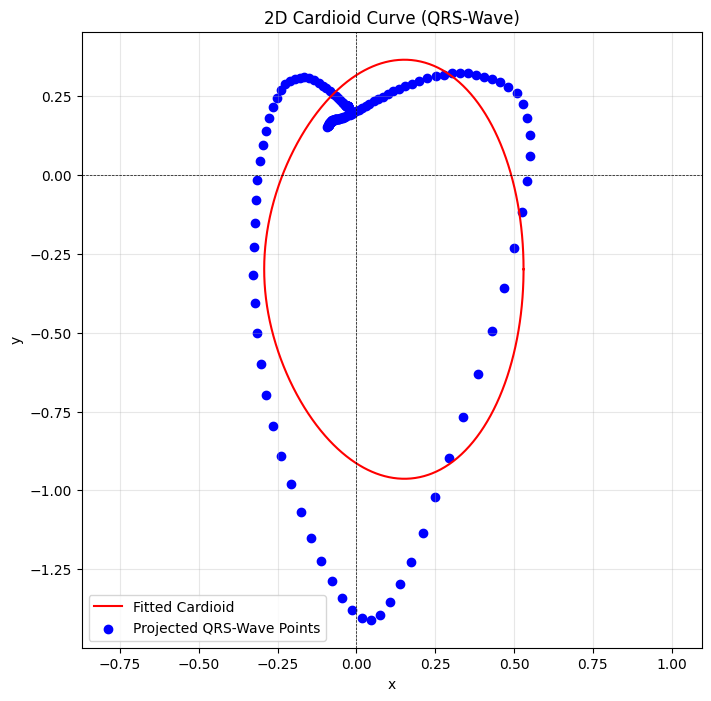

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# 1. t 값 범위 설정
t = np.linspace(0, 2 * np.pi, 1000)  # 0부터 2π까지 1000개의 점
# 2. x와 y 방정식 정의
x = 0.4114 * np.cos(t) +   0.0926 * (np.cos(t) ** 2) + 0.0264
y = 0.6313 * np.sin(t) + 0.2180 * np.sin(t) * np.cos(t) + -0.2986

# 3. 곡선 플롯
plt.figure(figsize=(8, 8))
plt.plot(x, y, color='red', label='Fitted Cardioid')
plt.scatter(x_2d, y_2d, color='blue', label='Projected QRS-Wave Points')  # QRS-Wave 데이터 투영 좌표
plt.title("2D Cardioid Curve (QRS-Wave)")
plt.xlabel("x")
plt.ylabel("y")
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.axvline(0, color='black', linewidth=0.5, linestyle='--')
plt.grid(alpha=0.3)
plt.legend()
plt.axis('equal')  # 축 비율을 동일하게 설정
plt.show()


plane_x · plane_y: 1.6653345369377348e-16
plane_x · normal_vector: -2.7755575615628914e-17
plane_y · normal_vector: -2.636779683484747e-16


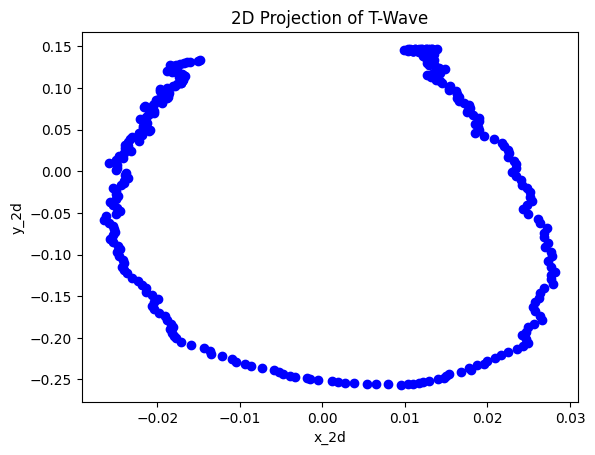

PCA 기반 평면 방정식: -0.4850x + 0.8565y + -0.1766z + -0.0273 = 0
x 방정식 추정: x = 0.0466 * cos(t) + 0.0009 * cos^2(t) + 0.0014
y 방정식 추정: y = 0.1391 * sin(t) + 0.0467 * sin(t) * cos(t) + -0.0240


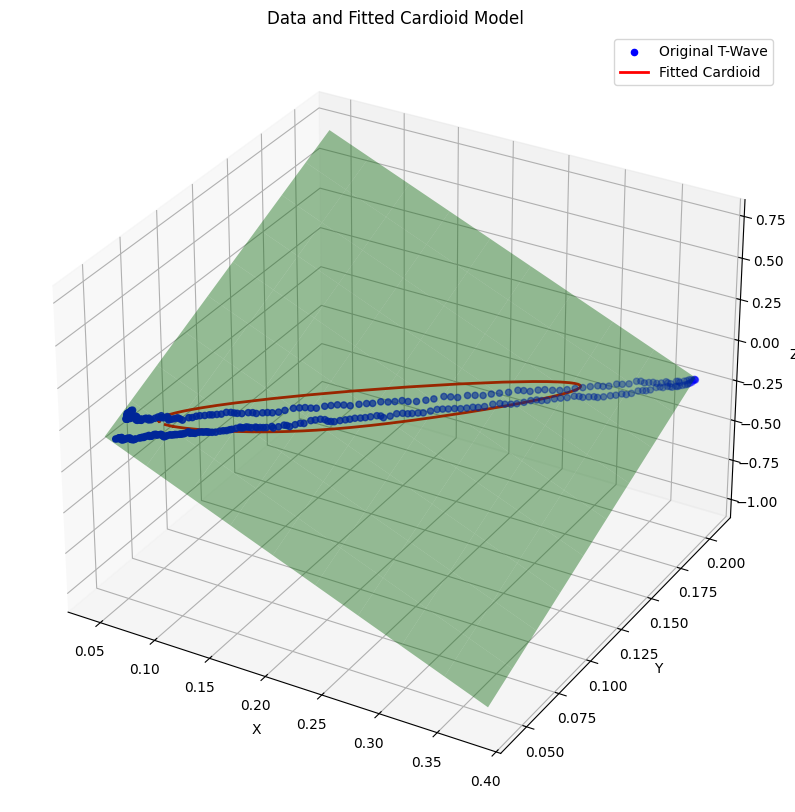

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 1. 데이터 로드
t_vx = t_wave['vx']
t_vy = t_wave['vy']
t_vz = t_wave['vz']

points = np.column_stack((t_vx, t_vy, t_vz))

# 2. PCA 기반 평면 계산
centroid = np.mean(points, axis=0)
centered = points - centroid
cov = np.cov(centered.T)
eigvals, eigvecs = np.linalg.eigh(cov)
normal_vector = eigvecs[:, 0]  # 가장 작은 고유값에 대응되는 벡터
A_pca, B_pca, C_pca = normal_vector
D_pca = -np.dot(normal_vector, centroid)

# PCA 평면의 직교성 확인
plane_x = eigvecs[:, 1]
plane_y = eigvecs[:, 2]

print("plane_x · plane_y:", np.dot(plane_x, plane_y))
print("plane_x · normal_vector:", np.dot(plane_x, normal_vector))
print("plane_y · normal_vector:", np.dot(plane_y, normal_vector))

# 3. 평면 기준 좌표계로 투영된 데이터 (2D)
t_proj_2d = np.dot(centered, np.vstack([plane_x, plane_y]).T)
x_2d, y_2d = t_proj_2d[:, 0], t_proj_2d[:, 1]

# 투영된 데이터 시각화
plt.scatter(x_2d, y_2d, color='blue')
plt.title("2D Projection of T-Wave")
plt.xlabel("x_2d")
plt.ylabel("y_2d")
plt.show()

# 4. 2D 상에서 카디오이드 회귀
t = np.arctan2(y_2d, x_2d)  # 각도를 기반으로 t 계산

# 선형 회귀를 위한 설계 행렬
cos_t = np.cos(t)
cos2_t = cos_t**2
sin_t = np.sin(t)
sin_cos_t = sin_t * cos_t
ones = np.ones_like(t)

A_x = np.vstack([cos_t, cos2_t, ones]).T
A_y = np.vstack([sin_t, sin_cos_t, ones]).T

coeffs_x, *_ = np.linalg.lstsq(A_x, x_2d, rcond=None)
coeffs_y, *_ = np.linalg.lstsq(A_y, y_2d, rcond=None)

# 모델 2D 곡선 생성
x_fit = A_x @ coeffs_x
y_fit = A_y @ coeffs_y

# 다시 3D로 변환 (투영 좌표계를 원래 공간으로 복원)
cardioid_3d = np.outer(x_fit, plane_x) + np.outer(y_fit, plane_y) + centroid

# 5. 결과 출력
print(f"PCA 기반 평면 방정식: {A_pca:.4f}x + {B_pca:.4f}y + {C_pca:.4f}z + {D_pca:.4f} = 0")
print(f"x 방정식 추정: x = {coeffs_x[0]:.4f} * cos(t) + {coeffs_x[1]:.4f} * cos^2(t) + {coeffs_x[2]:.4f}")
print(f"y 방정식 추정: y = {coeffs_y[0]:.4f} * sin(t) + {coeffs_y[1]:.4f} * sin(t) * cos(t) + {coeffs_y[2]:.4f}")

# 6. 시각화
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# 원본 데이터
ax.scatter(t_vx, t_vy, t_vz, color='blue', label='Original T-Wave')

# 회귀된 카디오이드
ax.plot(cardioid_3d[:, 0], cardioid_3d[:, 1], cardioid_3d[:, 2], color='red', linewidth=2, label='Fitted Cardioid')

# PCA 평면 시각화
xx, yy = np.meshgrid(
    np.linspace(np.min(t_vx), np.max(t_vx), 10),
    np.linspace(np.min(t_vy), np.max(t_vy), 10)
)
zz = (-A_pca * xx - B_pca * yy - D_pca) / C_pca
ax.plot_surface(xx, yy, zz, alpha=0.4, color='green')

# 라벨 및 범례
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Data and Fitted Cardioid Model')
ax.legend()
plt.show()


In [28]:
import numpy as np
import plotly.graph_objects as go

# 1. 데이터 로드
t_vx = t_wave['vx']
t_vy = t_wave['vy']
t_vz = t_wave['vz']

points = np.column_stack((t_vx, t_vy, t_vz))

# 2. PCA 기반 평면 계산
centroid = np.mean(points, axis=0)
centered = points - centroid
cov = np.cov(centered.T)
eigvals, eigvecs = np.linalg.eigh(cov)
normal_vector = eigvecs[:, 0]  # 가장 작은 고유값에 대응되는 벡터
A_pca, B_pca, C_pca = normal_vector
D_pca = -np.dot(normal_vector, centroid)

# PCA 평면의 직교성 확인
plane_x = eigvecs[:, 1]
plane_y = eigvecs[:, 2]

# 3. 평면 기준 좌표계로 투영된 데이터 (2D)
t_proj_2d = np.dot(centered, np.vstack([plane_x, plane_y]).T)
x_2d, y_2d = t_proj_2d[:, 0], t_proj_2d[:, 1]

# 4. 2D 상에서 카디오이드 회귀
t = np.arctan2(y_2d, x_2d)  # 각도를 기반으로 t 계산

# 선형 회귀를 위한 설계 행렬
cos_t = np.cos(t)
cos2_t = cos_t**2
sin_t = np.sin(t)
sin_cos_t = sin_t * cos_t
ones = np.ones_like(t)

A_x = np.vstack([cos_t, cos2_t, ones]).T
A_y = np.vstack([sin_t, sin_cos_t, ones]).T

coeffs_x, *_ = np.linalg.lstsq(A_x, x_2d, rcond=None)
coeffs_y, *_ = np.linalg.lstsq(A_y, y_2d, rcond=None)

# 모델 2D 곡선 생성
x_fit = A_x @ coeffs_x
y_fit = A_y @ coeffs_y

# 다시 3D로 변환 (투영 좌표계를 원래 공간으로 복원)
cardioid_3d = np.outer(x_fit, plane_x) + np.outer(y_fit, plane_y) + centroid

# 5. PCA 평면 생성
xx, yy = np.meshgrid(
    np.linspace(np.min(t_vx), np.max(t_vx), 10),
    np.linspace(np.min(t_vy), np.max(t_vy), 10)
)
zz = (-A_pca * xx - B_pca * yy - D_pca) / C_pca

# 6. Plotly 시각화
fig = go.Figure()

# 원본 데이터
fig.add_trace(go.Scatter3d(
    x=t_vx, y=t_vy, z=t_vz,
    mode='markers',
    marker=dict(size=3, color='blue'),
    name='Original T-Wave'
))

# 회귀된 카디오이드
fig.add_trace(go.Scatter3d(
    x=cardioid_3d[:, 0], y=cardioid_3d[:, 1], z=cardioid_3d[:, 2],
    mode='lines',
    line=dict(color='red', width=4),
    name='Fitted Cardioid'
))

# PCA 평면
fig.add_trace(go.Surface(
    x=xx, y=yy, z=zz,
    opacity=0.5,
    colorscale='Greens',
    name='PCA Plane'
))

# 레이아웃 설정
fig.update_layout(
    title="Data and Fitted Cardioid Model",
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    ),
    legend=dict(
        x=0.8, y=0.9
    )
)

fig.show()


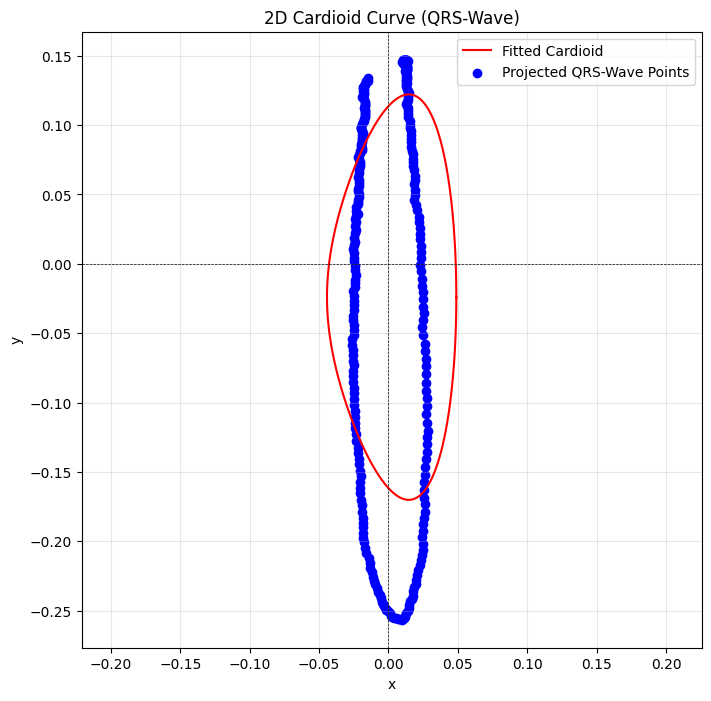

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# 1. t 값 범위 설정
t = np.linspace(0, 2 * np.pi, 1000)  # 0부터 2π까지 1000개의 점
# 2. x와 y 방정식 정의
x = 0.0466 * np.cos(t) +   0.0009 * (np.cos(t) ** 2) +  0.0014
y = 0.1391 * np.sin(t) + 0.0467 * np.sin(t) * np.cos(t) + -0.0240

# 3. 곡선 플롯
plt.figure(figsize=(8, 8))
plt.plot(x, y, color='red', label='Fitted Cardioid')
plt.scatter(x_2d, y_2d, color='blue', label='Projected QRS-Wave Points')  # QRS-Wave 데이터 투영 좌표
plt.title("2D Cardioid Curve (QRS-Wave)")
plt.xlabel("x")
plt.ylabel("y")
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.axvline(0, color='black', linewidth=0.5, linestyle='--')
plt.grid(alpha=0.3)
plt.legend()
plt.axis('equal')  # 축 비율을 동일하게 설정
plt.show()


#회전

plane_x · plane_y: 0.0
plane_x · normal_vector: 1.6653345369377348e-16
plane_y · normal_vector: -2.220446049250313e-16


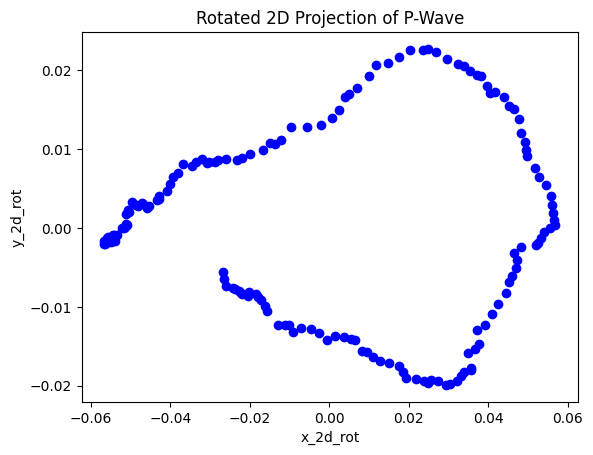

PCA 기반 평면 방정식: -0.6373x + 0.5526y + 0.5371z + 0.0015 = 0
x 방정식 추정: x = 0.0413 * cos(t) + 0.0041 * cos^2(t) + -0.0016
y 방정식 추정: y = 0.0214 * sin(t) + 0.0088 * sin(t) * cos(t) + 0.0007


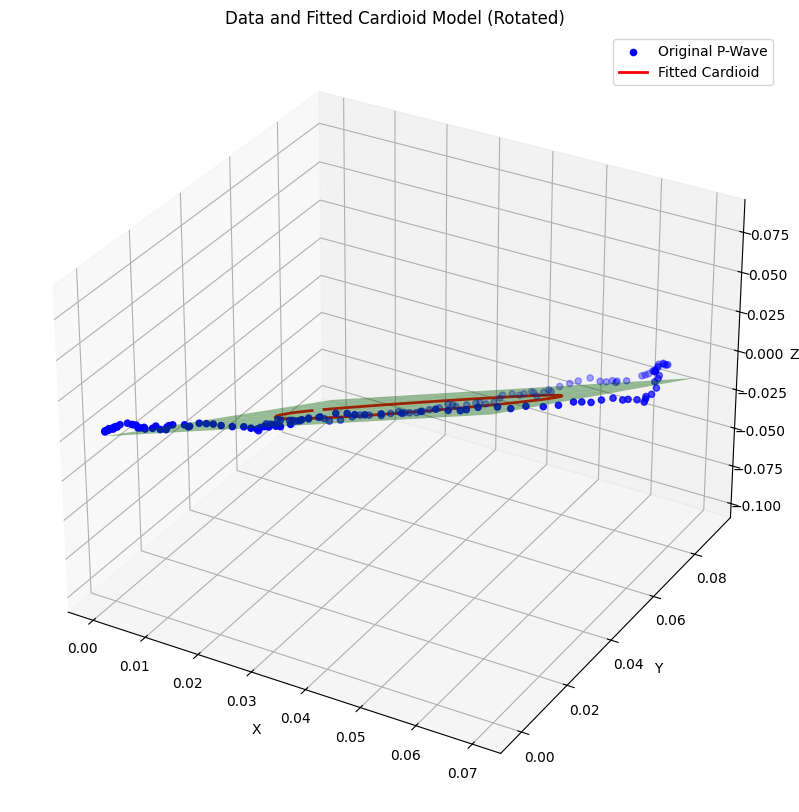

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 1. 데이터 로드
p_vx = p_wave['vx']
p_vy = p_wave['vy']
p_vz = p_wave['vz']

points = np.column_stack((p_vx, p_vy, p_vz))

# 2. PCA 기반 평면 계산
centroid = np.mean(points, axis=0)
centered = points - centroid
cov = np.cov(centered.T)
eigvals, eigvecs = np.linalg.eigh(cov)
normal_vector = eigvecs[:, 0]  # 가장 작은 고유값에 대응되는 벡터
A_pca, B_pca, C_pca = normal_vector
D_pca = -np.dot(normal_vector, centroid)

# PCA 평면의 직교성 확인
plane_x = eigvecs[:, 1]
plane_y = eigvecs[:, 2]

print("plane_x · plane_y:", np.dot(plane_x, plane_y))
print("plane_x · normal_vector:", np.dot(plane_x, normal_vector))
print("plane_y · normal_vector:", np.dot(plane_y, normal_vector))

# 3. 평면 기준 좌표계로 투영된 데이터 (2D)
p_proj_2d = np.dot(centered, np.vstack([plane_x, plane_y]).T)
x_2d, y_2d = p_proj_2d[:, 0], p_proj_2d[:, 1]

# 90도 회전을 위한 회전 행렬
theta = np.pi / 2  # 90도
rotation_matrix = np.array([
    [np.cos(theta), -np.sin(theta)],
    [np.sin(theta), np.cos(theta)]
])

# 2D 데이터 회전
rotated_2d = np.dot(np.column_stack((x_2d, y_2d)), rotation_matrix.T)
x_2d_rot, y_2d_rot = rotated_2d[:, 0], rotated_2d[:, 1]

# 회전된 데이터 시각화
plt.scatter(x_2d_rot, y_2d_rot, color='blue')
plt.title("Rotated 2D Projection of P-Wave")
plt.xlabel("x_2d_rot")
plt.ylabel("y_2d_rot")
plt.show()

# 4. 2D 상에서 카디오이드 회귀
t = np.arctan2(y_2d_rot, x_2d_rot)  # 각도를 기반으로 t 계산

# 선형 회귀를 위한 설계 행렬
cos_t = np.cos(t)
cos2_t = cos_t**2
sin_t = np.sin(t)
sin_cos_t = sin_t * cos_t
ones = np.ones_like(t)

A_x = np.vstack([cos_t, cos2_t, ones]).T
A_y = np.vstack([sin_t, sin_cos_t, ones]).T

coeffs_x, *_ = np.linalg.lstsq(A_x, x_2d_rot, rcond=None)
coeffs_y, *_ = np.linalg.lstsq(A_y, y_2d_rot, rcond=None)

# 모델 2D 곡선 생성
x_fit = A_x @ coeffs_x
y_fit = A_y @ coeffs_y

# 다시 3D로 변환 (투영 좌표계를 원래 공간으로 복원)
cardioid_3d = np.outer(x_fit, plane_x) + np.outer(y_fit, plane_y) + centroid

# 5. 결과 출력
print(f"PCA 기반 평면 방정식: {A_pca:.4f}x + {B_pca:.4f}y + {C_pca:.4f}z + {D_pca:.4f} = 0")
print(f"x 방정식 추정: x = {coeffs_x[0]:.4f} * cos(t) + {coeffs_x[1]:.4f} * cos^2(t) + {coeffs_x[2]:.4f}")
print(f"y 방정식 추정: y = {coeffs_y[0]:.4f} * sin(t) + {coeffs_y[1]:.4f} * sin(t) * cos(t) + {coeffs_y[2]:.4f}")

# 6. 시각화
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# 원본 데이터
ax.scatter(p_vx, p_vy, p_vz, color='blue', label='Original P-Wave')

# 회귀된 카디오이드
ax.plot(cardioid_3d[:, 0], cardioid_3d[:, 1], cardioid_3d[:, 2], color='red', linewidth=2, label='Fitted Cardioid')

# PCA 평면 시각화
xx, yy = np.meshgrid(
    np.linspace(np.min(p_vx), np.max(p_vx), 10),
    np.linspace(np.min(p_vy), np.max(p_vy), 10)
)
zz = (-A_pca * xx - B_pca * yy - D_pca) / C_pca
ax.plot_surface(xx, yy, zz, alpha=0.4, color='green')

# 라벨 및 범례
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Data and Fitted Cardioid Model (Rotated)')
ax.legend()
plt.show()


In [7]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go

# 1. 데이터 로드
p_vx = p_wave['vx']
p_vy = p_wave['vy']
p_vz = p_wave['vz']

points = np.column_stack((p_vx, p_vy, p_vz))

# 2. PCA 기반 평면 계산
centroid = np.mean(points, axis=0)
centered = points - centroid
cov = np.cov(centered.T)
eigvals, eigvecs = np.linalg.eigh(cov)
normal_vector = eigvecs[:, 0]  # 가장 작은 고유값에 대응되는 벡터
A_pca, B_pca, C_pca = normal_vector
D_pca = -np.dot(normal_vector, centroid)

# PCA 평면의 직교성 확인
plane_x = eigvecs[:, 1]
plane_y = eigvecs[:, 2]

# 3. 평면 기준 좌표계로 투영된 데이터 (2D)
p_proj_2d = np.dot(centered, np.vstack([plane_x, plane_y]).T)
x_2d, y_2d = p_proj_2d[:, 0], p_proj_2d[:, 1]

# 90도 회전을 위한 회전 행렬
theta = np.pi / 2  # 90도
rotation_matrix = np.array([
    [np.cos(theta), -np.sin(theta)],
    [np.sin(theta), np.cos(theta)]
])

# 2D 데이터 회전
rotated_2d = np.dot(np.column_stack((x_2d, y_2d)), rotation_matrix.T)
x_2d_rot, y_2d_rot = rotated_2d[:, 0], rotated_2d[:, 1]

# 4. 2D 상에서 카디오이드 회귀
t = np.arctan2(y_2d_rot, x_2d_rot)  # 각도를 기반으로 t 계산

# 선형 회귀를 위한 설계 행렬
cos_t = np.cos(t)
cos2_t = cos_t**2
sin_t = np.sin(t)
sin_cos_t = sin_t * cos_t
ones = np.ones_like(t)

A_x = np.vstack([cos_t, cos2_t, ones]).T
A_y = np.vstack([sin_t, sin_cos_t, ones]).T

coeffs_x, *_ = np.linalg.lstsq(A_x, x_2d_rot, rcond=None)
coeffs_y, *_ = np.linalg.lstsq(A_y, y_2d_rot, rcond=None)

# 모델 2D 곡선 생성
x_fit = A_x @ coeffs_x
y_fit = A_y @ coeffs_y

# 다시 3D로 변환 (투영 좌표계를 원래 공간으로 복원)
cardioid_3d = np.outer(x_fit, plane_x) + np.outer(y_fit, plane_y) + centroid

# 5. PCA 평면 생성
xx, yy = np.meshgrid(
    np.linspace(np.min(p_vx), np.max(p_vx), 10),
    np.linspace(np.min(p_vy), np.max(p_vy), 10)
)
zz = (-A_pca * xx - B_pca * yy - D_pca) / C_pca

# 6. Plotly 시각화
fig = go.Figure()

# 원본 데이터
fig.add_trace(go.Scatter3d(
    x=p_vx, y=p_vy, z=p_vz,
    mode='markers',
    marker=dict(size=3, color='blue'),
    name='Original P-Wave'
))

# 회귀된 카디오이드
fig.add_trace(go.Scatter3d(
    x=cardioid_3d[:, 0], y=cardioid_3d[:, 1], z=cardioid_3d[:, 2],
    mode='lines',
    line=dict(color='red', width=4),
    name='Fitted Cardioid'
))

# PCA 평면
fig.add_trace(go.Surface(
    x=xx, y=yy, z=zz,
    opacity=0.5,
    colorscale='Greens',
    name='PCA Plane'
))

# 레이아웃 설정
fig.update_layout(
    title="Data and Fitted Cardioid Model (Rotated)",
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    ),
    legend=dict(
        x=0.8, y=0.9
    )
)

fig.show()


MSE (x): 0.003985
MSE (y): 0.000650
Total MSE: 0.002317


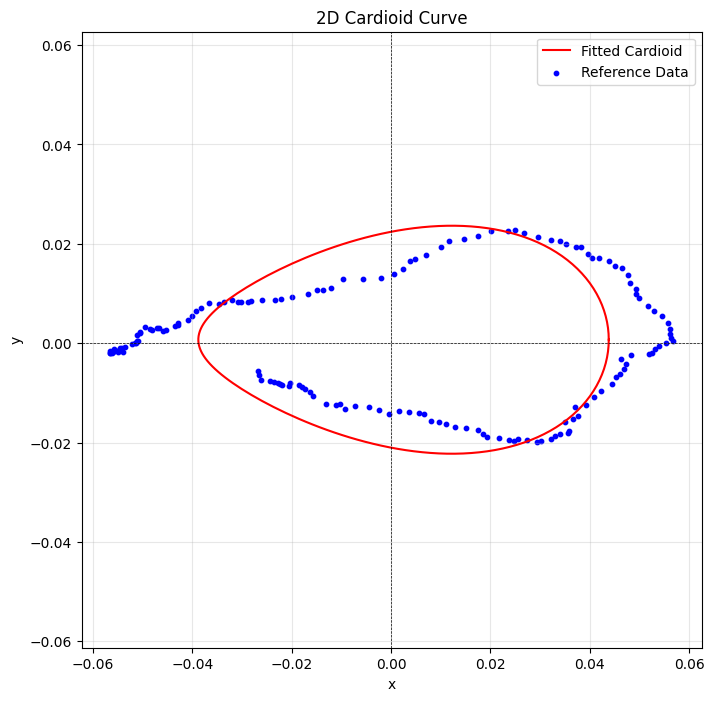

In [46]:
import numpy as np
import matplotlib.pyplot as plt

# 1. t 값 범위 설정
t = np.linspace(0, 2 * np.pi, 160)  # 0부터 2π까지 1000개의 점

# 2. x와 y 방정식 정의
x = 0.0413 * np.cos(t) + 0.0041 * (np.cos(t) ** 2) - 0.0016
y = 0.0214 * np.sin(t) + 0.0088 * np.sin(t) * np.cos(t) + 0.0007

# 4. MSE 계산
mse_x = np.mean((x - x_2d_rot) ** 2)  # x 방향의 MSE
mse_y = np.mean((y - y_2d_rot) ** 2)  # y 방향의 MSE
mse_total = (mse_x + mse_y) / 2       # 전체 MSE

print(f"MSE (x): {mse_x:.6f}")
print(f"MSE (y): {mse_y:.6f}")
print(f"Total MSE: {mse_total:.6f}")

# 5. 곡선 플롯
plt.figure(figsize=(8, 8))
plt.plot(x, y, color='red', label='Fitted Cardioid')
plt.scatter(x_2d_rot, y_2d_rot, color='blue', s=10, label='Reference Data')
plt.title("2D Cardioid Curve")
plt.xlabel("x")
plt.ylabel("y")
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.axvline(0, color='black', linewidth=0.5, linestyle='--')
plt.grid(alpha=0.3)
plt.legend()
plt.axis('equal')  # 축 비율을 동일하게 설정
plt.show()


plane_x · plane_y: 0.0
plane_x · normal_vector: 1.1102230246251565e-16
plane_y · normal_vector: -8.456776945386935e-17


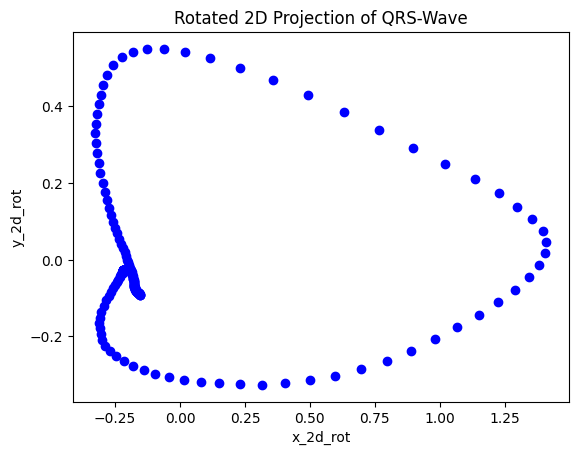

PCA 기반 평면 방정식: -0.3928x + 0.9098y + -0.1342z + -0.0225 = 0
x 방정식 추정: x = 0.6391 * cos(t) + 0.5636 * cos^2(t) + -0.1041
y 방정식 추정: y = 0.4798 * sin(t) + 0.1640 * sin(t) * cos(t) + 0.0384


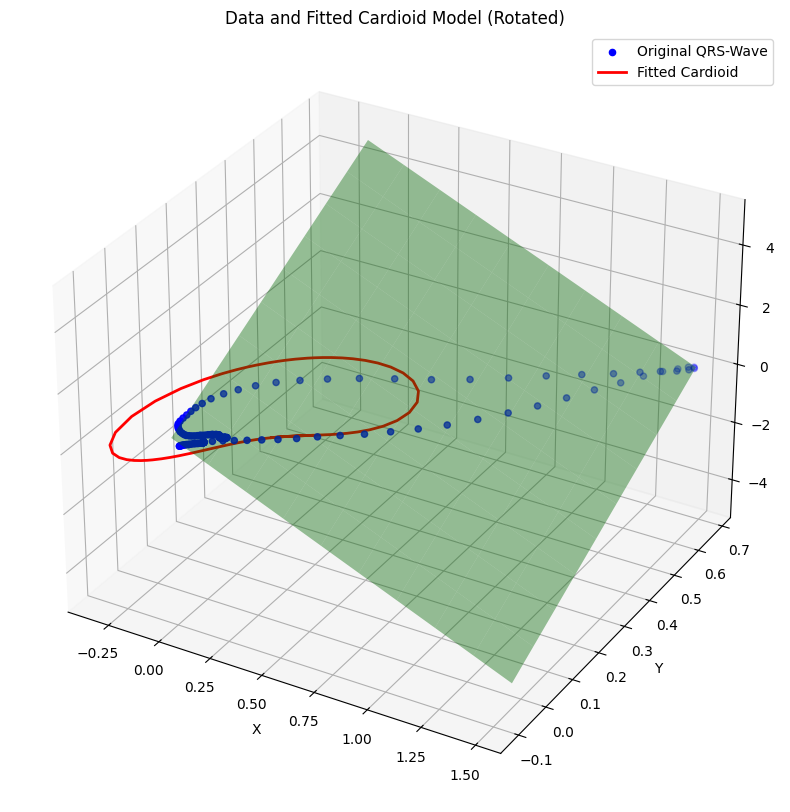

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 1. 데이터 로드
qrs_vx = qrs_wave['vx']
qrs_vy = qrs_wave['vy']
qrs_vz = qrs_wave['vz']

points = np.column_stack((qrs_vx, qrs_vy, qrs_vz))

# 2. PCA 기반 평면 계산
centroid = np.mean(points, axis=0)
centered = points - centroid
cov = np.cov(centered.T)
eigvals, eigvecs = np.linalg.eigh(cov)
normal_vector = eigvecs[:, 0]  # 가장 작은 고유값에 대응되는 벡터
A_pca, B_pca, C_pca = normal_vector
D_pca = -np.dot(normal_vector, centroid)

# PCA 평면의 직교성 확인
plane_x = eigvecs[:, 1]
plane_y = eigvecs[:, 2]

print("plane_x · plane_y:", np.dot(plane_x, plane_y))
print("plane_x · normal_vector:", np.dot(plane_x, normal_vector))
print("plane_y · normal_vector:", np.dot(plane_y, normal_vector))

# 3. 평면 기준 좌표계로 투영된 데이터 (2D)
qrs_proj_2d = np.dot(centered, np.vstack([plane_x, plane_y]).T)
x_2d, y_2d = qrs_proj_2d[:, 0], qrs_proj_2d[:, 1]

# 90도 회전을 위한 회전 행렬
theta = np.pi / 2  # 90도
rotation_matrix = np.array([
    [np.cos(theta), -np.sin(theta)],
    [np.sin(theta), np.cos(theta)]
])

# 2D 데이터 회전
rotated_2d = np.dot(np.column_stack((x_2d, y_2d)), rotation_matrix.T)
x_2d_rot, y_2d_rot = rotated_2d[:, 0], rotated_2d[:, 1]

# 회전된 데이터 시각화
plt.scatter(x_2d_rot, y_2d_rot, color='blue')
plt.title("Rotated 2D Projection of QRS-Wave")
plt.xlabel("x_2d_rot")
plt.ylabel("y_2d_rot")
plt.show()

# 4. 2D 상에서 카디오이드 회귀
t = np.arctan2(y_2d_rot, x_2d_rot)  # 각도를 기반으로 t 계산

# 선형 회귀를 위한 설계 행렬
cos_t = np.cos(t)
cos2_t = cos_t**2
sin_t = np.sin(t)
sin_cos_t = sin_t * cos_t
ones = np.ones_like(t)

A_x = np.vstack([cos_t, cos2_t, ones]).T
A_y = np.vstack([sin_t, sin_cos_t, ones]).T

coeffs_x, *_ = np.linalg.lstsq(A_x, x_2d_rot, rcond=None)
coeffs_y, *_ = np.linalg.lstsq(A_y, y_2d_rot, rcond=None)

# 모델 2D 곡선 생성
x_fit = A_x @ coeffs_x
y_fit = A_y @ coeffs_y

# 다시 3D로 변환 (투영 좌표계를 원래 공간으로 복원)
cardioid_3d = np.outer(x_fit, plane_x) + np.outer(y_fit, plane_y) + centroid

# 5. 결과 출력
print(f"PCA 기반 평면 방정식: {A_pca:.4f}x + {B_pca:.4f}y + {C_pca:.4f}z + {D_pca:.4f} = 0")
print(f"x 방정식 추정: x = {coeffs_x[0]:.4f} * cos(t) + {coeffs_x[1]:.4f} * cos^2(t) + {coeffs_x[2]:.4f}")
print(f"y 방정식 추정: y = {coeffs_y[0]:.4f} * sin(t) + {coeffs_y[1]:.4f} * sin(t) * cos(t) + {coeffs_y[2]:.4f}")

# 6. 시각화
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# 원본 데이터
ax.scatter(qrs_vx, qrs_vy, qrs_vz, color='blue', label='Original QRS-Wave')

# 회귀된 카디오이드
ax.plot(cardioid_3d[:, 0], cardioid_3d[:, 1], cardioid_3d[:, 2], color='red', linewidth=2, label='Fitted Cardioid')

# PCA 평면 시각화
xx, yy = np.meshgrid(
    np.linspace(np.min(qrs_vx), np.max(qrs_vx), 10),
    np.linspace(np.min(qrs_vy), np.max(qrs_vy), 10)
)
zz = (-A_pca * xx - B_pca * yy - D_pca) / C_pca
ax.plot_surface(xx, yy, zz, alpha=0.4, color='green')

# 라벨 및 범례
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Data and Fitted Cardioid Model (Rotated)')
ax.legend()
plt.show()


In [25]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go

# 1. 데이터 로드
qrs_vx = qrs_wave['vx']
qrs_vy = qrs_wave['vy']
qrs_vz = qrs_wave['vz']

points = np.column_stack((qrs_vx, qrs_vy, qrs_vz))

# 2. PCA 기반 평면 계산
centroid = np.mean(points, axis=0)
centered = points - centroid
cov = np.cov(centered.T)
eigvals, eigvecs = np.linalg.eigh(cov)
normal_vector = eigvecs[:, 0]  # 가장 작은 고유값에 대응되는 벡터
A_pca, B_pca, C_pca = normal_vector
D_pca = -np.dot(normal_vector, centroid)

# PCA 평면의 직교성 확인
plane_x = eigvecs[:, 1]
plane_y = eigvecs[:, 2]

# 3. 평면 기준 좌표계로 투영된 데이터 (2D)
qrs_proj_2d = np.dot(centered, np.vstack([plane_x, plane_y]).T)
x_2d, y_2d = qrs_proj_2d[:, 0], qrs_proj_2d[:, 1]

# 90도 회전을 위한 회전 행렬
theta = np.pi / 2  # 90도
rotation_matrix = np.array([
    [np.cos(theta), -np.sin(theta)],
    [np.sin(theta), np.cos(theta)]
])

# 2D 데이터 회전
rotated_2d = np.dot(np.column_stack((x_2d, y_2d)), rotation_matrix.T)
x_2d_rot, y_2d_rot = rotated_2d[:, 0], rotated_2d[:, 1]

# 4. 2D 상에서 카디오이드 회귀
t = np.arctan2(y_2d_rot, x_2d_rot)  # 각도를 기반으로 t 계산

# 선형 회귀를 위한 설계 행렬
cos_t = np.cos(t)
cos2_t = cos_t**2
sin_t = np.sin(t)
sin_cos_t = sin_t * cos_t
ones = np.ones_like(t)

A_x = np.vstack([cos_t, cos2_t, ones]).T
A_y = np.vstack([sin_t, sin_cos_t, ones]).T

coeffs_x, *_ = np.linalg.lstsq(A_x, x_2d_rot, rcond=None)
coeffs_y, *_ = np.linalg.lstsq(A_y, y_2d_rot, rcond=None)

# 모델 2D 곡선 생성
x_fit = A_x @ coeffs_x
y_fit = A_y @ coeffs_y

# 다시 3D로 변환 (투영 좌표계를 원래 공간으로 복원)
cardioid_3d = np.outer(x_fit, plane_x) + np.outer(y_fit, plane_y) + centroid

# 5. PCA 평면 생성
xx, yy = np.meshgrid(
    np.linspace(np.min(qrs_vx), np.max(qrs_vx), 10),
    np.linspace(np.min(qrs_vy), np.max(qrs_vy), 10)
)
zz = (-A_pca * xx - B_pca * yy - D_pca) / C_pca

# 6. Plotly 시각화
fig = go.Figure()

# 원본 데이터
fig.add_trace(go.Scatter3d(
    x=qrs_vx, y=qrs_vy, z=qrs_vz,
    mode='markers',
    marker=dict(size=3, color='blue'),
    name='Original QRS-Wave'
))

# 회귀된 카디오이드
fig.add_trace(go.Scatter3d(
    x=cardioid_3d[:, 0], y=cardioid_3d[:, 1], z=cardioid_3d[:, 2],
    mode='lines',
    line=dict(color='red', width=4),
    name='Fitted Cardioid'
))

# PCA 평면
fig.add_trace(go.Surface(
    x=xx, y=yy, z=zz,
    opacity=0.5,
    colorscale='Greens',
    name='PCA Plane'
))

# 레이아웃 설정
fig.update_layout(
    title="Data and Fitted Cardioid Model (Rotated)",
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    ),
    legend=dict(
        x=0.8, y=0.9
    )
)

fig.show()


MSE (x): 0.673509
MSE (y): 0.192240
Total MSE: 0.432874


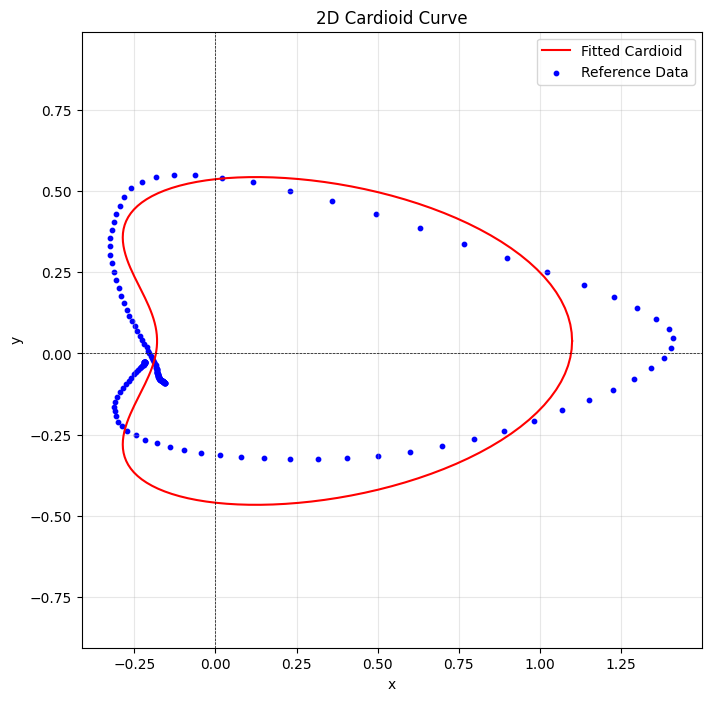

In [50]:
import numpy as np
import matplotlib.pyplot as plt

# 1. t 값 범위 설정
t = np.linspace(0, 2 * np.pi, 160)  # 0부터 2π까지 1000개의 점

# 2. x와 y 방정식 정의
x = 0.6391 * np.cos(t) + 0.5636 * (np.cos(t) ** 2) - 0.1041
y = 0.4798 * np.sin(t) + 0.1640 * np.sin(t) * np.cos(t) + 0.0384

# 4. MSE 계산
mse_x = np.mean((x - x_2d_rot) ** 2)  # x 방향의 MSE
mse_y = np.mean((y - y_2d_rot) ** 2)  # y 방향의 MSE
mse_total = (mse_x + mse_y) / 2       # 전체 MSE

print(f"MSE (x): {mse_x:.6f}")
print(f"MSE (y): {mse_y:.6f}")
print(f"Total MSE: {mse_total:.6f}")

# 5. 곡선 플롯
plt.figure(figsize=(8, 8))
plt.plot(x, y, color='red', label='Fitted Cardioid')
plt.scatter(x_2d_rot, y_2d_rot, color='blue', s=10, label='Reference Data')
plt.title("2D Cardioid Curve")
plt.xlabel("x")
plt.ylabel("y")
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.axvline(0, color='black', linewidth=0.5, linestyle='--')
plt.grid(alpha=0.3)
plt.legend()
plt.axis('equal')  # 축 비율을 동일하게 설정
plt.show()


plane_x · plane_y: 1.6653345369377348e-16
plane_x · normal_vector: -2.7755575615628914e-17
plane_y · normal_vector: -2.636779683484747e-16


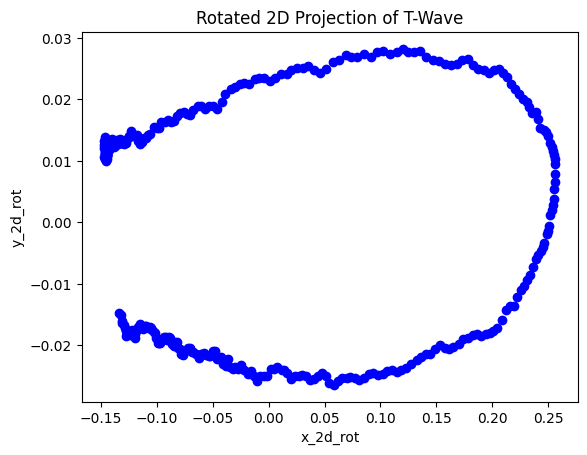

PCA 기반 평면 방정식: -0.4850x + 0.8565y + -0.1766z + -0.0273 = 0
x 방정식 추정: x = 0.1391 * cos(t) + 0.0449 * cos^2(t) + -0.0155
y 방정식 추정: y = 0.0466 * sin(t) + 0.0012 * sin(t) * cos(t) + 0.0015


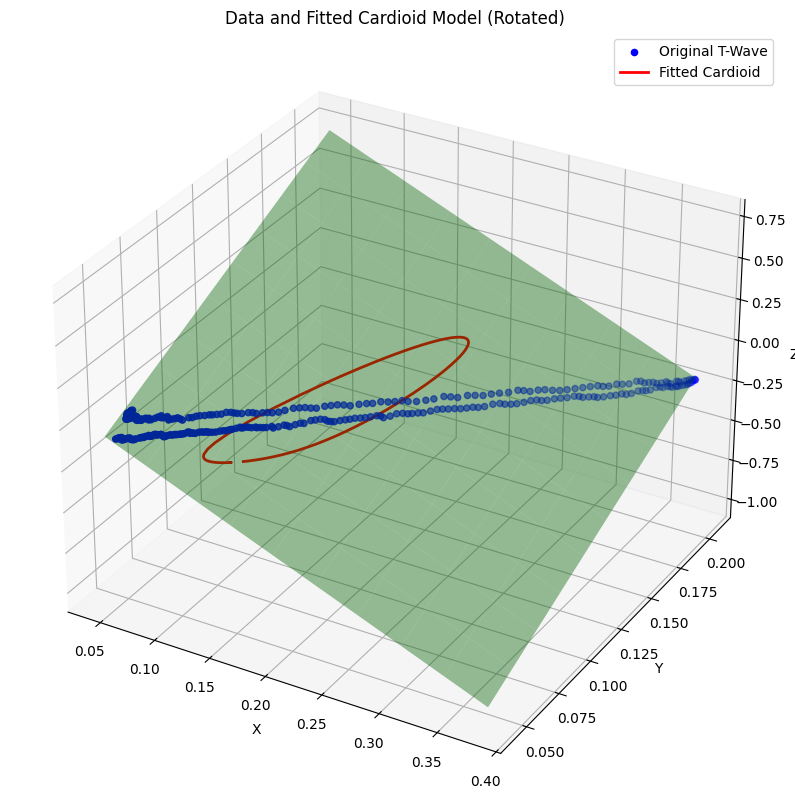

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 1. 데이터 로드
t_vx = t_wave['vx']
t_vy = t_wave['vy']
t_vz = t_wave['vz']

points = np.column_stack((t_vx, t_vy, t_vz))

# 2. PCA 기반 평면 계산
centroid = np.mean(points, axis=0)
centered = points - centroid
cov = np.cov(centered.T)
eigvals, eigvecs = np.linalg.eigh(cov)
normal_vector = eigvecs[:, 0]  # 가장 작은 고유값에 대응되는 벡터
A_pca, B_pca, C_pca = normal_vector
D_pca = -np.dot(normal_vector, centroid)

# PCA 평면의 직교성 확인
plane_x = eigvecs[:, 1]
plane_y = eigvecs[:, 2]

print("plane_x · plane_y:", np.dot(plane_x, plane_y))
print("plane_x · normal_vector:", np.dot(plane_x, normal_vector))
print("plane_y · normal_vector:", np.dot(plane_y, normal_vector))

# 3. 평면 기준 좌표계로 투영된 데이터 (2D)
t_proj_2d = np.dot(centered, np.vstack([plane_x, plane_y]).T)
x_2d, y_2d = t_proj_2d[:, 0], t_proj_2d[:, 1]

# 90도 회전을 위한 회전 행렬
theta = np.pi / 2  # 90도
rotation_matrix = np.array([
    [np.cos(theta), -np.sin(theta)],
    [np.sin(theta), np.cos(theta)]
])

# 2D 데이터 회전
rotated_2d = np.dot(np.column_stack((x_2d, y_2d)), rotation_matrix.T)
x_2d_rot, y_2d_rot = rotated_2d[:, 0], rotated_2d[:, 1]

# 회전된 데이터 시각화
plt.scatter(x_2d_rot, y_2d_rot, color='blue')
plt.title("Rotated 2D Projection of T-Wave")
plt.xlabel("x_2d_rot")
plt.ylabel("y_2d_rot")
plt.show()

# 4. 2D 상에서 카디오이드 회귀
t = np.arctan2(y_2d_rot, x_2d_rot)  # 각도를 기반으로 t 계산

# 선형 회귀를 위한 설계 행렬
cos_t = np.cos(t)
cos2_t = cos_t**2
sin_t = np.sin(t)
sin_cos_t = sin_t * cos_t
ones = np.ones_like(t)

A_x = np.vstack([cos_t, cos2_t, ones]).T
A_y = np.vstack([sin_t, sin_cos_t, ones]).T

coeffs_x, *_ = np.linalg.lstsq(A_x, x_2d_rot, rcond=None)
coeffs_y, *_ = np.linalg.lstsq(A_y, y_2d_rot, rcond=None)

# 모델 2D 곡선 생성
x_fit = A_x @ coeffs_x
y_fit = A_y @ coeffs_y

# 다시 3D로 변환 (투영 좌표계를 원래 공간으로 복원)
cardioid_3d = np.outer(x_fit, plane_x) + np.outer(y_fit, plane_y) + centroid

# 5. 결과 출력
print(f"PCA 기반 평면 방정식: {A_pca:.4f}x + {B_pca:.4f}y + {C_pca:.4f}z + {D_pca:.4f} = 0")
print(f"x 방정식 추정: x = {coeffs_x[0]:.4f} * cos(t) + {coeffs_x[1]:.4f} * cos^2(t) + {coeffs_x[2]:.4f}")
print(f"y 방정식 추정: y = {coeffs_y[0]:.4f} * sin(t) + {coeffs_y[1]:.4f} * sin(t) * cos(t) + {coeffs_y[2]:.4f}")

# 6. 시각화
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# 원본 데이터
ax.scatter(t_vx, t_vy, t_vz, color='blue', label='Original T-Wave')

# 회귀된 카디오이드
ax.plot(cardioid_3d[:, 0], cardioid_3d[:, 1], cardioid_3d[:, 2], color='red', linewidth=2, label='Fitted Cardioid')

# PCA 평면 시각화
xx, yy = np.meshgrid(
    np.linspace(np.min(t_vx), np.max(t_vx), 10),
    np.linspace(np.min(t_vy), np.max(t_vy), 10)
)
zz = (-A_pca * xx - B_pca * yy - D_pca) / C_pca
ax.plot_surface(xx, yy, zz, alpha=0.4, color='green')

# 라벨 및 범례
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Data and Fitted Cardioid Model (Rotated)')
ax.legend()
plt.show()


In [31]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go

# 1. 데이터 로드
t_vx = t_wave['vx']
t_vy = t_wave['vy']
t_vz = t_wave['vz']

points = np.column_stack((t_vx, t_vy, t_vz))

# 2. PCA 기반 평면 계산
centroid = np.mean(points, axis=0)
centered = points - centroid
cov = np.cov(centered.T)
eigvals, eigvecs = np.linalg.eigh(cov)
normal_vector = eigvecs[:, 0]  # 가장 작은 고유값에 대응되는 벡터
A_pca, B_pca, C_pca = normal_vector
D_pca = -np.dot(normal_vector, centroid)

# PCA 평면의 직교성 확인
plane_x = eigvecs[:, 1]
plane_y = eigvecs[:, 2]

# 3. 평면 기준 좌표계로 투영된 데이터 (2D)
t_proj_2d = np.dot(centered, np.vstack([plane_x, plane_y]).T)
x_2d, y_2d = t_proj_2d[:, 0], t_proj_2d[:, 1]

# 90도 회전을 위한 회전 행렬
theta = np.pi / 2  # 90도
rotation_matrix = np.array([
    [np.cos(theta), -np.sin(theta)],
    [np.sin(theta), np.cos(theta)]
])

# 2D 데이터 회전
rotated_2d = np.dot(np.column_stack((x_2d, y_2d)), rotation_matrix.T)
x_2d_rot, y_2d_rot = rotated_2d[:, 0], rotated_2d[:, 1]

# 4. 2D 상에서 카디오이드 회귀
t = np.arctan2(y_2d_rot, x_2d_rot)  # 각도를 기반으로 t 계산

# 선형 회귀를 위한 설계 행렬
cos_t = np.cos(t)
cos2_t = cos_t**2
sin_t = np.sin(t)
sin_cos_t = sin_t * cos_t
ones = np.ones_like(t)

A_x = np.vstack([cos_t, cos2_t, ones]).T
A_y = np.vstack([sin_t, sin_cos_t, ones]).T

coeffs_x, *_ = np.linalg.lstsq(A_x, x_2d_rot, rcond=None)
coeffs_y, *_ = np.linalg.lstsq(A_y, y_2d_rot, rcond=None)

# 모델 2D 곡선 생성
x_fit = A_x @ coeffs_x
y_fit = A_y @ coeffs_y

# 다시 3D로 변환 (투영 좌표계를 원래 공간으로 복원)
cardioid_3d = np.outer(x_fit, plane_x) + np.outer(y_fit, plane_y) + centroid

# 5. PCA 평면 생성
xx, yy = np.meshgrid(
    np.linspace(np.min(t_vx), np.max(t_vx), 10),
    np.linspace(np.min(t_vy), np.max(t_vy), 10)
)
zz = (-A_pca * xx - B_pca * yy - D_pca) / C_pca

# 6. Plotly 시각화
fig = go.Figure()

# 원본 데이터
fig.add_trace(go.Scatter3d(
    x=t_vx, y=t_vy, z=t_vz,
    mode='markers',
    marker=dict(size=3, color='blue'),
    name='Original T-Wave'
))

# 회귀된 카디오이드
fig.add_trace(go.Scatter3d(
    x=cardioid_3d[:, 0], y=cardioid_3d[:, 1], z=cardioid_3d[:, 2],
    mode='lines',
    line=dict(color='red', width=4),
    name='Fitted Cardioid'
))

# PCA 평면
fig.add_trace(go.Surface(
    x=xx, y=yy, z=zz,
    opacity=0.5,
    colorscale='Greens',
    name='PCA Plane'
))

# 레이아웃 설정
fig.update_layout(
    title="Data and Fitted Cardioid Model (Rotated)",
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    ),
    legend=dict(
        x=0.8, y=0.9
    )
)

fig.show()


MSE (x): 0.052395
MSE (y): 0.002568
Total MSE: 0.027482


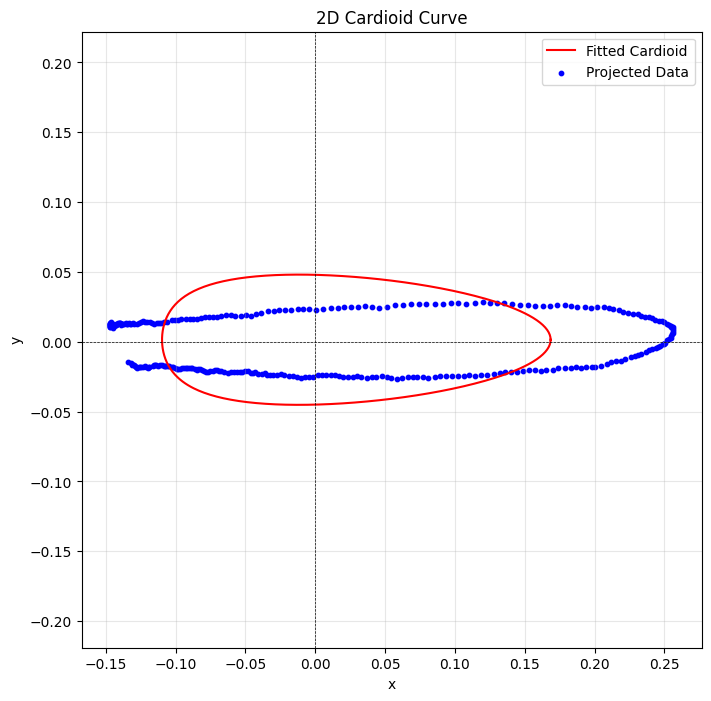

In [53]:
import numpy as np
import matplotlib.pyplot as plt

# 1. t 값 범위 설정
t = np.linspace(0, 2 * np.pi, 340)  # 0부터 2π까지 1000개의 점

# 2. x와 y 방정식 정의
x = 0.1391 * np.cos(t) + 0.0449 * (np.cos(t) ** 2) - 0.0155
y = 0.0466 * np.sin(t) + 0.0012 * np.sin(t) * np.cos(t) + 0.0015

# 4. MSE 계산
mse_x = np.mean((x - x_2d_rot) ** 2)  # x 방향의 MSE
mse_y = np.mean((y - y_2d_rot) ** 2)  # y 방향의 MSE
mse_total = (mse_x + mse_y) / 2       # 전체 MSE

print(f"MSE (x): {mse_x:.6f}")
print(f"MSE (y): {mse_y:.6f}")
print(f"Total MSE: {mse_total:.6f}")

# 5. 곡선 플롯
plt.figure(figsize=(8, 8))
plt.plot(x, y, color='red', label='Fitted Cardioid')
plt.scatter(x_2d_rot, y_2d_rot, color='blue', s=10, label='Projected Data')
plt.title("2D Cardioid Curve")
plt.xlabel("x")
plt.ylabel("y")
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.axvline(0, color='black', linewidth=0.5, linestyle='--')
plt.grid(alpha=0.3)
plt.legend()
plt.axis('equal')  # 축 비율을 동일하게 설정
plt.show()


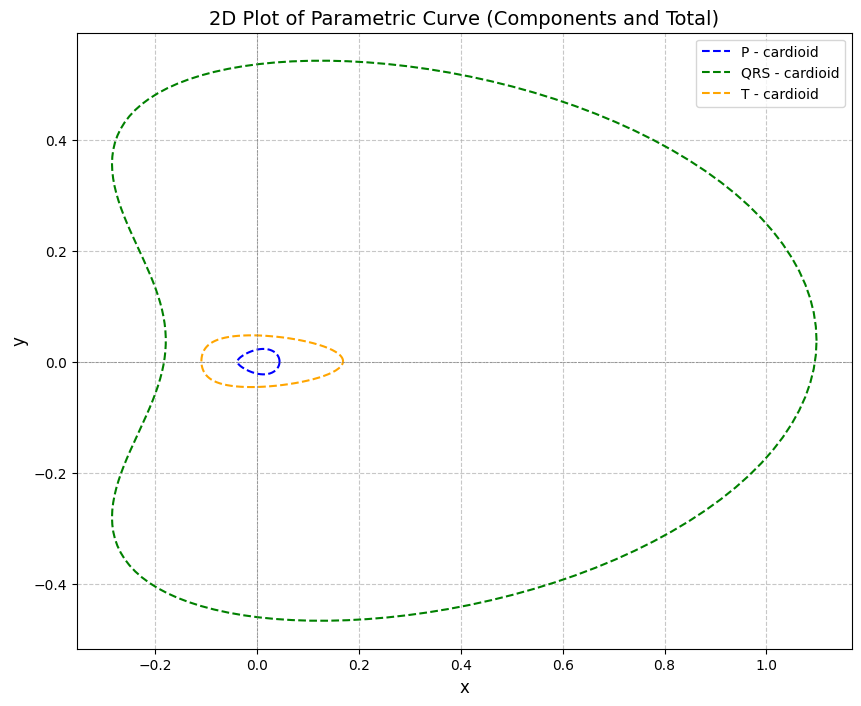

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# t 값 정의 (0부터 2π까지 160개 점)
t = np.linspace(0, 2 * np.pi, 160)

x1 = 0.0413 * np.cos(t) + 0.0041 * (np.cos(t) ** 2) - 0.0016
y1 = 0.0214 * np.sin(t) + 0.0088 * np.sin(t) * np.cos(t) + 0.0007

x2 = 0.6391 * np.cos(t) + 0.5636 * (np.cos(t) ** 2) - 0.1041
y2 = 0.4798 * np.sin(t) + 0.1640 * np.sin(t) * np.cos(t) + 0.0384

x3 = 0.1391 * np.cos(t) + 0.0449 * (np.cos(t) ** 2) -0.0155
y3 = 0.0466 * np.sin(t) + 0.0012 * np.sin(t) * np.cos(t) + 0.0015

# 2D 플롯
plt.figure(figsize=(10, 8))

# 각 구성 요소 플롯
plt.plot(x1, y1, label='P - cardioid', linestyle='--', color='blue')
plt.plot(x2, y2, label='QRS - cardioid', linestyle='--', color='green')
plt.plot(x3, y3, label='T - cardioid', linestyle='--', color='orange')

# 그래프 설정
plt.title('2D Plot of Parametric Curve (Components and Total)', fontsize=14)
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()


# gradient boosting

P Wave original 3D data points: 160
P Wave PCA 2D transformed points: 160
P Wave optimized params: a=-0.0443, b=-0.1196, c=-0.0155, d=0.0006
P Wave MSE: 0.000000



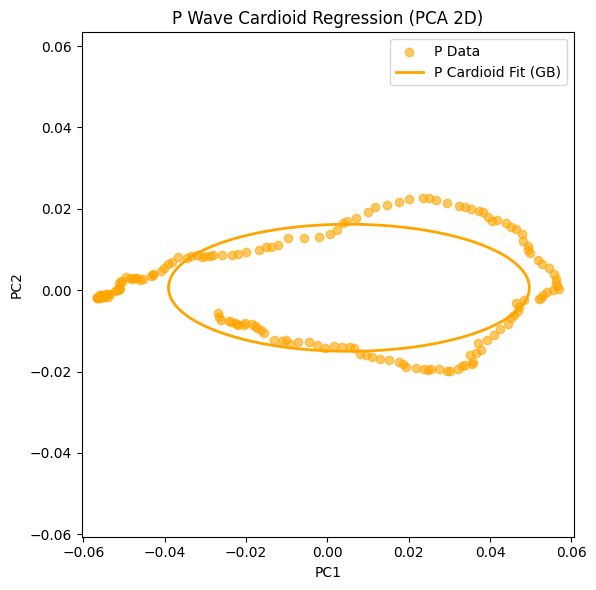

QRS Wave original 3D data points: 160
QRS Wave PCA 2D transformed points: 160
QRS Wave optimized params: a=-0.7955, b=-0.7314, c=-0.3885, d=0.0049
QRS Wave MSE: 0.000006



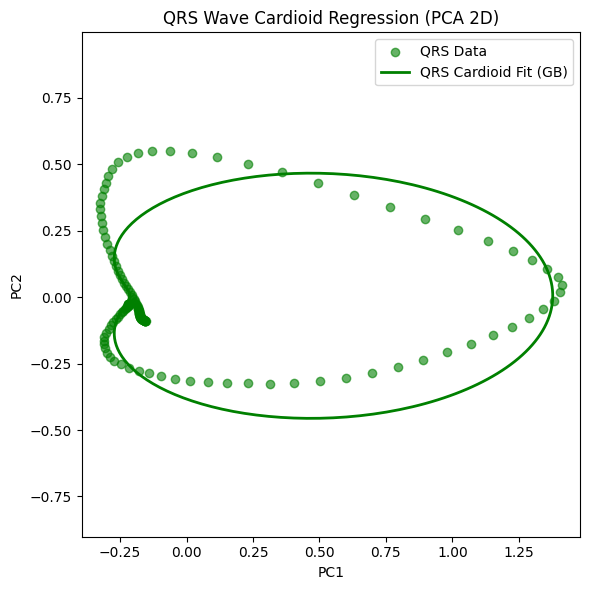

T Wave original 3D data points: 340
T Wave PCA 2D transformed points: 340
T Wave optimized params: a=-0.1779, b=-0.3428, c=-0.0300, d=0.0016
T Wave MSE: 0.000002



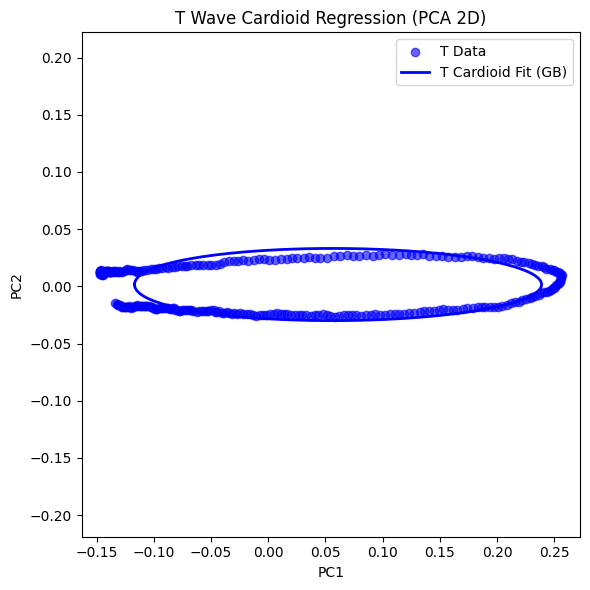

In [35]:
from sklearn.ensemble import GradientBoostingRegressor
from scipy.optimize import minimize
from sklearn.decomposition import PCA

# 2. PCA 2D transform function
def apply_pca(data):
    pca = PCA(n_components=2)
    data_2d = pca.fit_transform(data)
    return data_2d

# 3. Calculate arc-length based t values (0 to 2pi)
def calc_arc_angle(data_2d):
    diffs = np.diff(data_2d, axis=0)
    dists = np.sqrt((diffs**2).sum(axis=1))
    cumulative = np.insert(np.cumsum(dists), 0, 0)
    total_length = cumulative[-1]
    t_new = 2*np.pi * cumulative / total_length
    return t_new

# 4. Cardioid parametric model (기존과 동일)
def cardioid_param(t, a, b, c, d):
    x = a * np.cos(t) * (1 + b * np.cos(t))
    y = c * np.sin(t) * (1 + b * np.cos(t)) + d
    return x, y

# 5. Residuals for Gradient Boosting fitting
def cardioid_residuals_gb(params, t, x_data, y_data):
    a, b, c, d = params
    x_model, y_model = cardioid_param(t, a, b, c, d)
    return np.mean((x_model - x_data)**2 + (y_model - y_data)**2)

# 6. Fit and plot function with Gradient Boosting for parameter estimation
def fit_and_plot_gb_params(data_3d, label, color):
    print(f"{label} Wave original 3D data points: {data_3d.shape[0]}")

    # PCA 적용
    data_2d = apply_pca(data_3d)
    print(f"{label} Wave PCA 2D transformed points: {data_2d.shape[0]}")

    # PCA 결과 분리
    x_data, y_data = data_2d[:, 0], data_2d[:, 1]

    # Arc-length 기반 t 값 계산
    t = calc_arc_angle(data_2d).reshape(-1, 1)  # t를 2D로 변환 (Gradient Boosting 입력 요구사항)

    # Gradient Boosting 모델 생성 및 훈련
    gb_x = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
    gb_y = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

    gb_x.fit(t, x_data)
    gb_y.fit(t, y_data)

    # t_fine으로 예측값 생성
    t_fine = np.linspace(0, 2 * np.pi, 300).reshape(-1, 1)
    x_fit = gb_x.predict(t_fine)
    y_fit = gb_y.predict(t_fine)

    # 모델 예측 값 계산
    x_model = gb_x.predict(t)
    y_model = gb_y.predict(t)

    # 초기 파라미터 추정 (Gradient Boosting 예측 값 기반)
    a0 = (np.max(x_model) - np.min(x_model)) / 2
    b0 = 0.5
    c0 = (np.max(y_model) - np.min(y_model)) / 2
    d0 = np.mean(y_model)
    initial_params = [a0, b0, c0, d0]

    # 최적화 수행 (Gradient Boosting 예측값을 기준으로 파라미터 피팅)
    result = minimize(cardioid_residuals_gb, initial_params, args=(t.flatten(), x_model, y_model), method='L-BFGS-B')
    a_opt, b_opt, c_opt, d_opt = result.x
    print(f"{label} Wave optimized params: a={a_opt:.4f}, b={b_opt:.4f}, c={c_opt:.4f}, d={d_opt:.4f}")

    # 최적화된 파라미터로 피팅 곡선 생성
    t_fine = np.linspace(0, 2 * np.pi, 300)
    x_fit, y_fit = cardioid_param(t_fine, a_opt, b_opt, c_opt, d_opt)

    # MSE 계산
    mse = np.mean((x_model - x_data)**2 + (y_model - y_data)**2)
    print(f"{label} Wave MSE: {mse:.6f}\n")

    # 시각화
    plt.figure(figsize=(6, 6))
    plt.scatter(x_data, y_data, label=f'{label} Data', alpha=0.6, color=color)
    plt.plot(x_fit, y_fit, label=f'{label} Cardioid Fit (GB)', color=color, linewidth=2)
    plt.title(f'{label} Wave Cardioid Regression (PCA 2D)')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.axis('equal')
    plt.legend()
    plt.tight_layout()
    plt.show()

# 7. Run all waves
fit_and_plot_gb_params(p_wave, 'P', 'orange')
fit_and_plot_gb_params(qrs_wave, 'QRS', 'green')
fit_and_plot_gb_params(t_wave, 'T', 'blue')


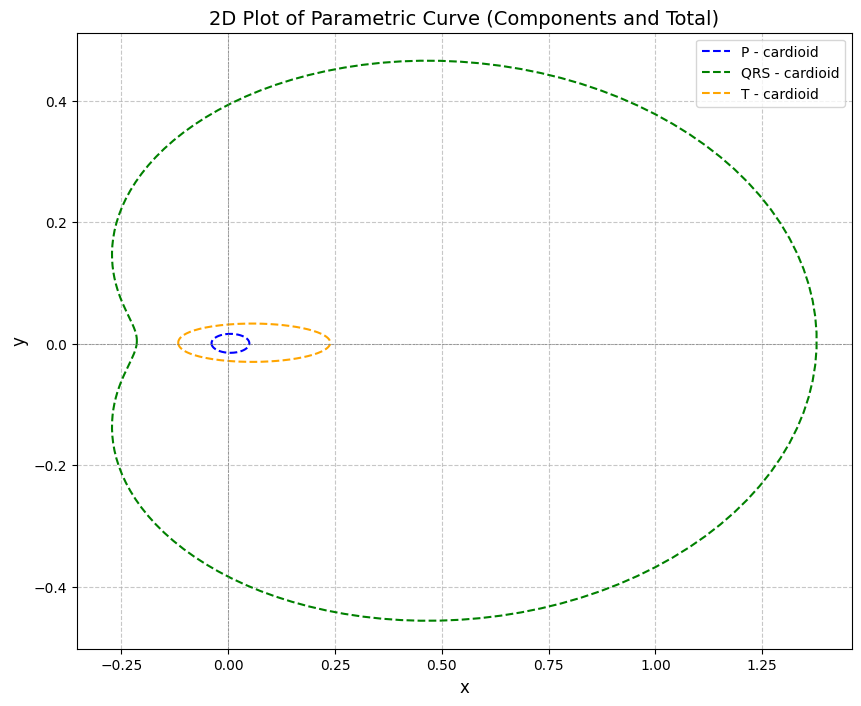

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# t 값 정의 (0부터 2π까지 160개 점)
t = np.linspace(0, 2 * np.pi, 160)

# x와 y의 각 구성 요소 계산
x1 = -0.0443 * np.cos(t) * (1 + -0.1196 * np.cos(t))
x2 = -0.7955 * np.cos(t) * (1 + -0.7314 * np.cos(t))
x3 = -0.1779 * np.cos(t) * (1 + -0.3428 * np.cos(t))

y1 = -0.0155 * np.sin(t) * (1 + -0.1196 * np.cos(t))+ 0.0006
y2 = -0.3885 * np.sin(t) * (1 + -0.7314 * np.cos(t)) + 0.0049
y3 = -0.0300 * np.sin(t) * (1 + -0.3428 * np.cos(t)) + 0.0016

# 2D 플롯
plt.figure(figsize=(10, 8))

# 각 구성 요소 플롯
plt.plot(x1, y1, label='P - cardioid', linestyle='--', color='blue')
plt.plot(x2, y2, label='QRS - cardioid', linestyle='--', color='green')
plt.plot(x3, y3, label='T - cardioid', linestyle='--', color='orange')

# 그래프 설정
plt.title('2D Plot of Parametric Curve (Components and Total)', fontsize=14)
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()
